In [72]:
### Run this cell before continuing.
library(tidyverse)
library(testthat)
library(tidymodels)
library(digest)
library(repr)
library(ggplot2)
library(cowplot)
options(repr.matrix.max.rows = 6)

options(warn=-1)

In [74]:
urlfile <-"https://raw.githubusercontent.com/ShahrukhP15/DSCI100_GroupProject_113/main/Heart_Disease_Prediction.csv"
original_heart_data <- read_csv(urlfile)

#Tidying Data

heart_data <- original_heart_data |> 
             select(Age,Sex,BP,Cholesterol,`ST depression`,`Heart Disease`) |>
             mutate(`Heart Disease` = as_factor(`Heart Disease`), Sex= as_factor(Sex))
head(heart_data)


Rows: 270 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): Heart Disease
dbl (13): Age, Sex, Chest pain type, BP, Cholesterol, FBS over 120, EKG resu...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Age,Sex,BP,Cholesterol,ST depression,Heart Disease,Heart_Disease
<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<chr>,<fct>
70,1,130,322,2.4,Presence,Presence
67,0,115,564,1.6,Absence,Absence
57,1,124,261,0.3,Presence,Presence
64,1,128,263,0.2,Absence,Absence
74,0,120,269,0.2,Absence,Absence
65,1,120,177,0.4,Absence,Absence


In [202]:
#Creating Training Data And Exploratory Data Analysis


set.seed(2022)
heart_split <- initial_split(heart_data, prop = 3/4, strata = `Heart Disease`)  
heart_train <- training(heart_split)   
heart_test <- testing(heart_split)

#summary of training data
num_obs <- nrow(heart_train)
heart_train |>
  group_by(`Heart Disease`) |>
  summarize(
   count = n(),
   percentage = n() / num_obs * 100,
   avg_BP = mean(BP),
   avg_cholesterol = mean(Cholesterol),
   avg_ST_depression = mean(`ST depression`))
options(warn=0)

hd_proportions <- group_by(heart_train,`Heart Disease`)|>
                  summarize(n=n())|>
                  mutate(percent=100*n/nrow(heart_train))
hd_proportions

Heart Disease,count,percentage,avg_BP,avg_cholesterol,avg_ST_depression
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Absence,112,55.44554,129.0893,244.0536,0.5473214
Presence,90,44.55446,134.5778,253.2556,1.6933333


Heart Disease,n,percent
<chr>,<int>,<dbl>
Absence,112,55.44554
Presence,90,44.55446


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font width unknown for character 0x9”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font width unknown for character 0x9”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font width unknown for character 0x9”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font width unknown for character 0x9”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font width unknown for character 0x9”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font width unknown for character 0x9”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font width unknown for character 0x9”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font width unknown for character 0x9”
Warning message in grid.Call(C_t

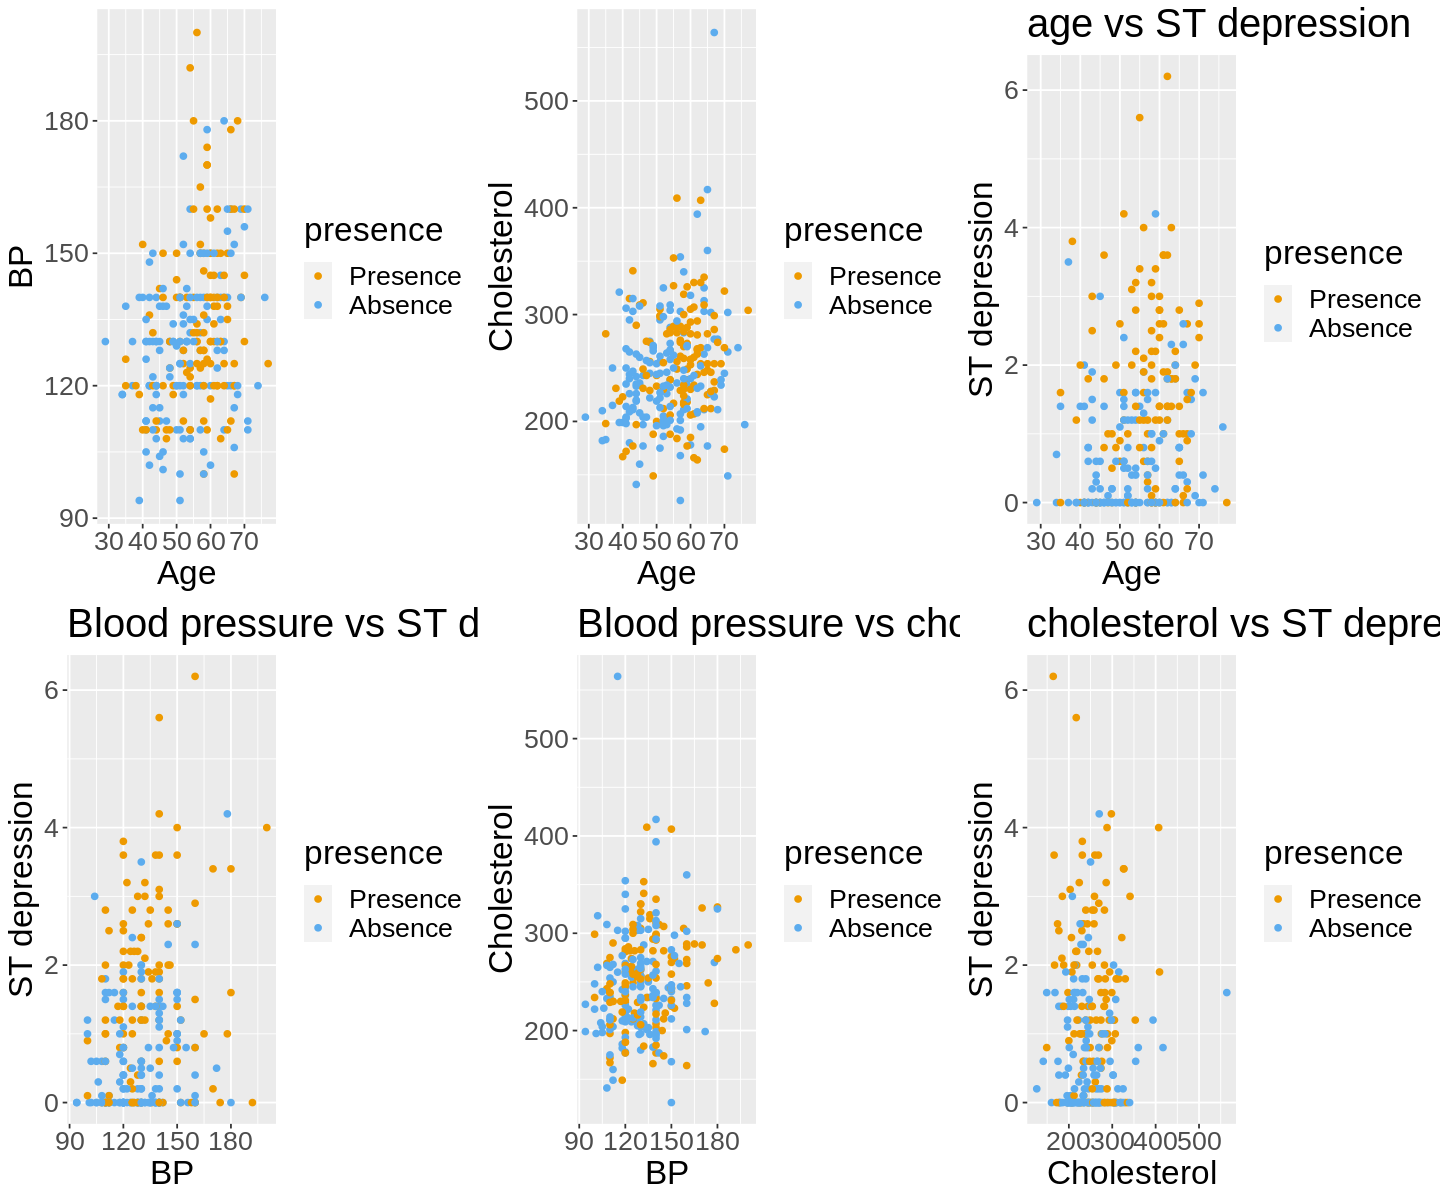

In [126]:
# making the best knn model base on different 4 variables(age, blood pressure, cholestrol, ST depression)
# separate into 6 model (age, blood pressure)(age, cholestrol)(age, ST depression)(blood pressure, ST depression)(blood pressure, cholestrol)
#(cholestrol,ST depression) 

age_blood <-heart_data |>
  ggplot(aes(x = Age, y = BP, color = `Heart Disease`)) +
  geom_point(alpha = 1) +
  labs(color = "presence") +
  scale_color_manual(labels = c("Presence", "Absence	"), 
                     values = c("orange2", "steelblue2")) + 
  theme(text = element_text(size = 20))

age_c <-heart_data |>
  ggplot(aes(x = Age, y = Cholesterol, color = `Heart Disease`)) +
  geom_point(alpha = 1) +
  labs(color = "presence") +
  scale_color_manual(labels = c("Presence", "Absence	"), 
                     values = c("orange2", "steelblue2")) + 
  theme(text = element_text(size = 20))
age_ST <-heart_data |>
  ggplot(aes(x = Age, y = `ST depression`, color = `Heart Disease`)) +
  geom_point(alpha = 1) +
  labs(color = "presence") +ggtitle("age vs ST depression")+
  scale_color_manual(labels = c("Presence", "Absence	"), 
                     values = c("orange2", "steelblue2")) + 
  theme(text = element_text(size = 20))

BP_ST <-heart_data |>
  ggplot(aes(x = BP, y = `ST depression`, color = `Heart Disease`)) +
  geom_point(alpha = 1) +
  labs(color = "presence") +ggtitle("Blood pressure vs ST depression")+
  scale_color_manual(labels = c("Presence", "Absence	"), 
                     values = c("orange2", "steelblue2")) + 
  theme(text = element_text(size = 20))

BP_CH <-heart_data |>
  ggplot(aes(x = BP, y = Cholesterol, color = `Heart Disease`)) +
  geom_point(alpha = 1) +
  labs(color = "presence") +ggtitle("Blood pressure vs cholesterol")+
  scale_color_manual(labels = c("Presence", "Absence	"), 
                     values = c("orange2", "steelblue2")) + 
  theme(text = element_text(size = 20))

CH_ST <-heart_data |>
  ggplot(aes(x = Cholesterol, y = `ST depression` , color = `Heart Disease`)) +
  geom_point(alpha = 1) +
  labs(color = "presence") +ggtitle("cholesterol vs ST depression")+
  scale_color_manual(labels = c("Presence", "Absence	"), 
                     values = c("orange2", "steelblue2")) + 
  theme(text = element_text(size = 20))
#plot six graph together
plot_grid(age_blood,age_c,age_ST,BP_ST,BP_CH,CH_ST)
options(repr.plot.width = 20 ,repr.plot.height = 15)
options(warn=-1)

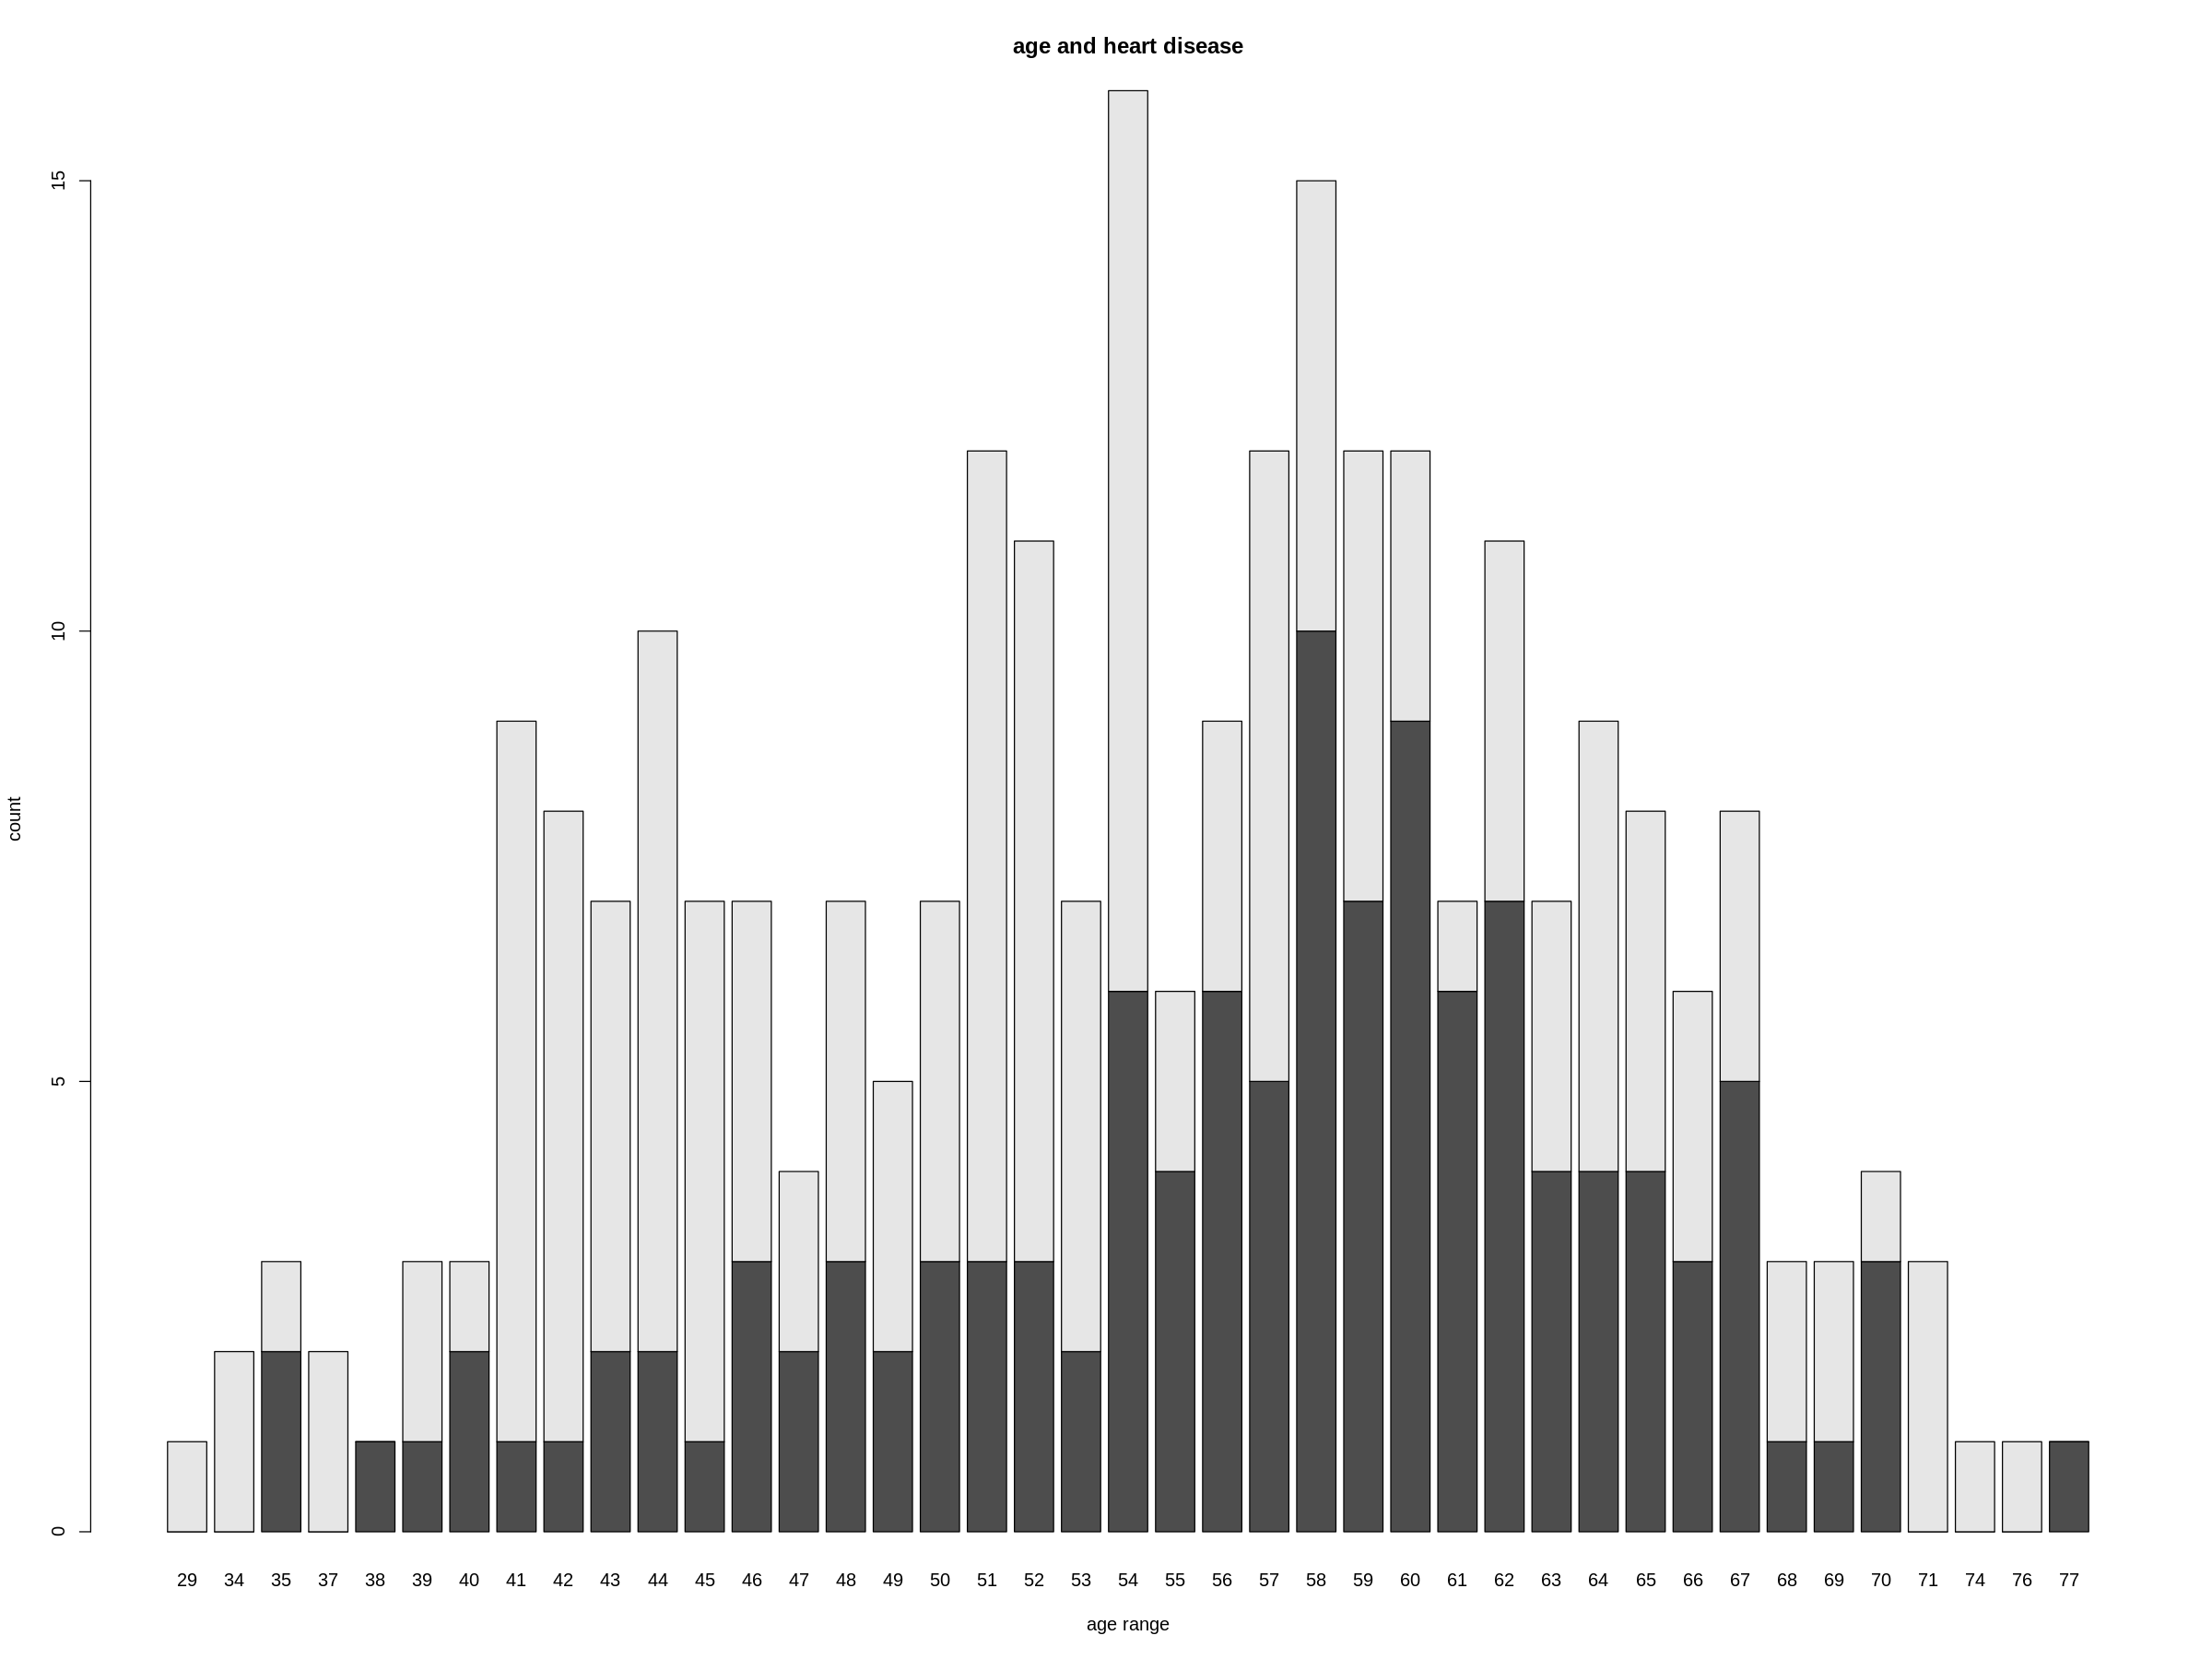

In [127]:
table1 <-table(heart_data$`Heart Disease`,heart_data$Age)
# a bar plot to see the trend line between age and disease
barplot(table1,
        beside = FALSE, 
        main = "age and heart disease",
        xlab = "age range",
        ylab= "count")
options(warn=0)
options(repr.plot.width = 12 ,repr.plot.height = 10)

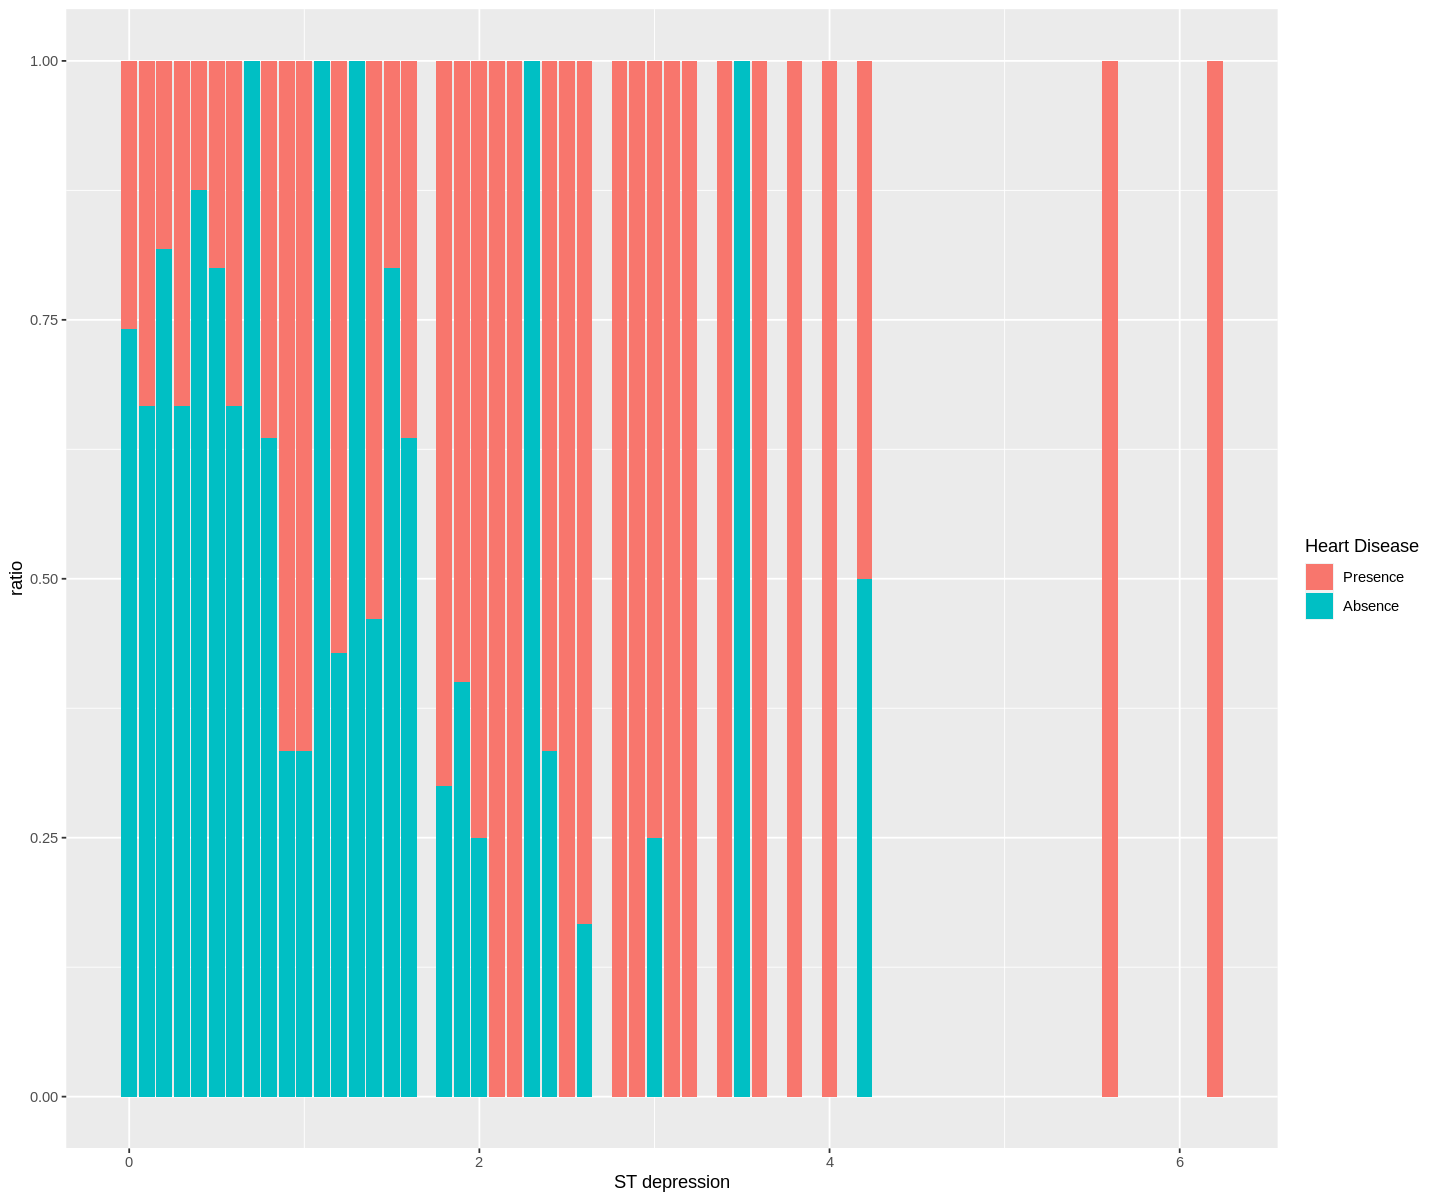

In [128]:
# different ages contains different amount of data, make it in proportion to clarify the trend
age_graph <- ggplot(data = heart_data, aes(x = `ST depression`, fill = `Heart Disease`)) + 
  geom_bar(position = "fill")+ylab("ratio")
age_graph

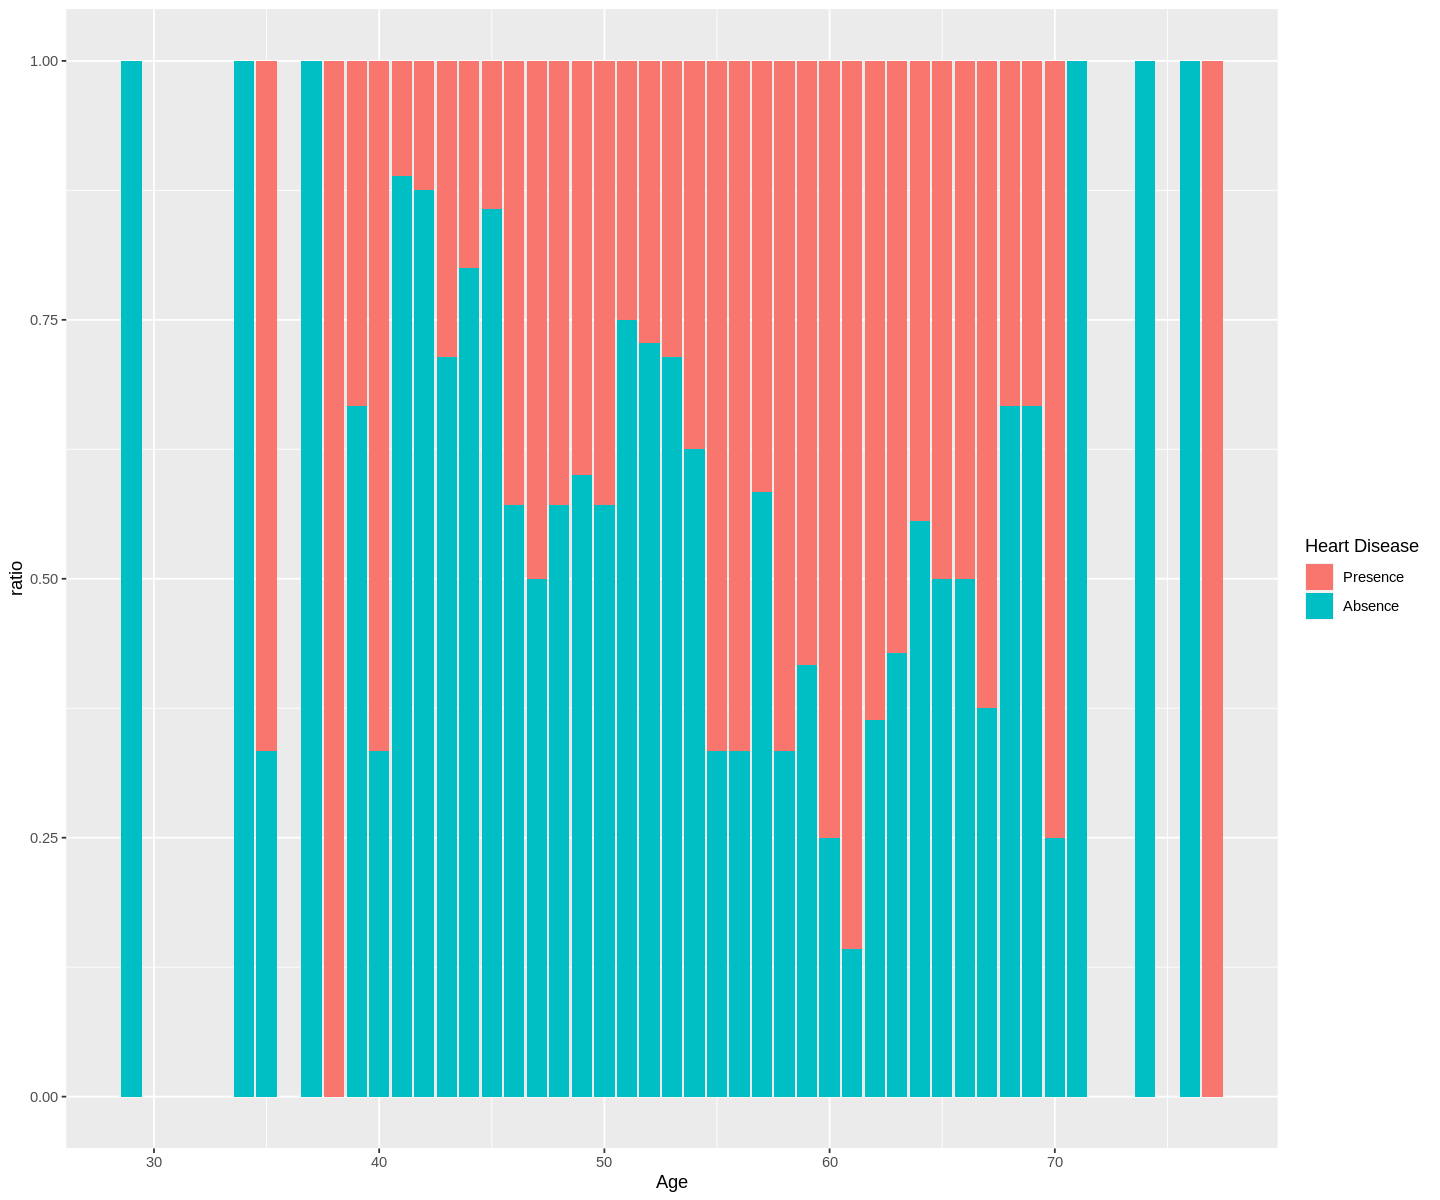

In [129]:
# the ST depression in proportion 
st_graph <- ggplot(data = heart_data, aes(x = Age, fill = `Heart Disease`)) + 
  geom_bar(position = "fill")+ylab("ratio")
st_graph

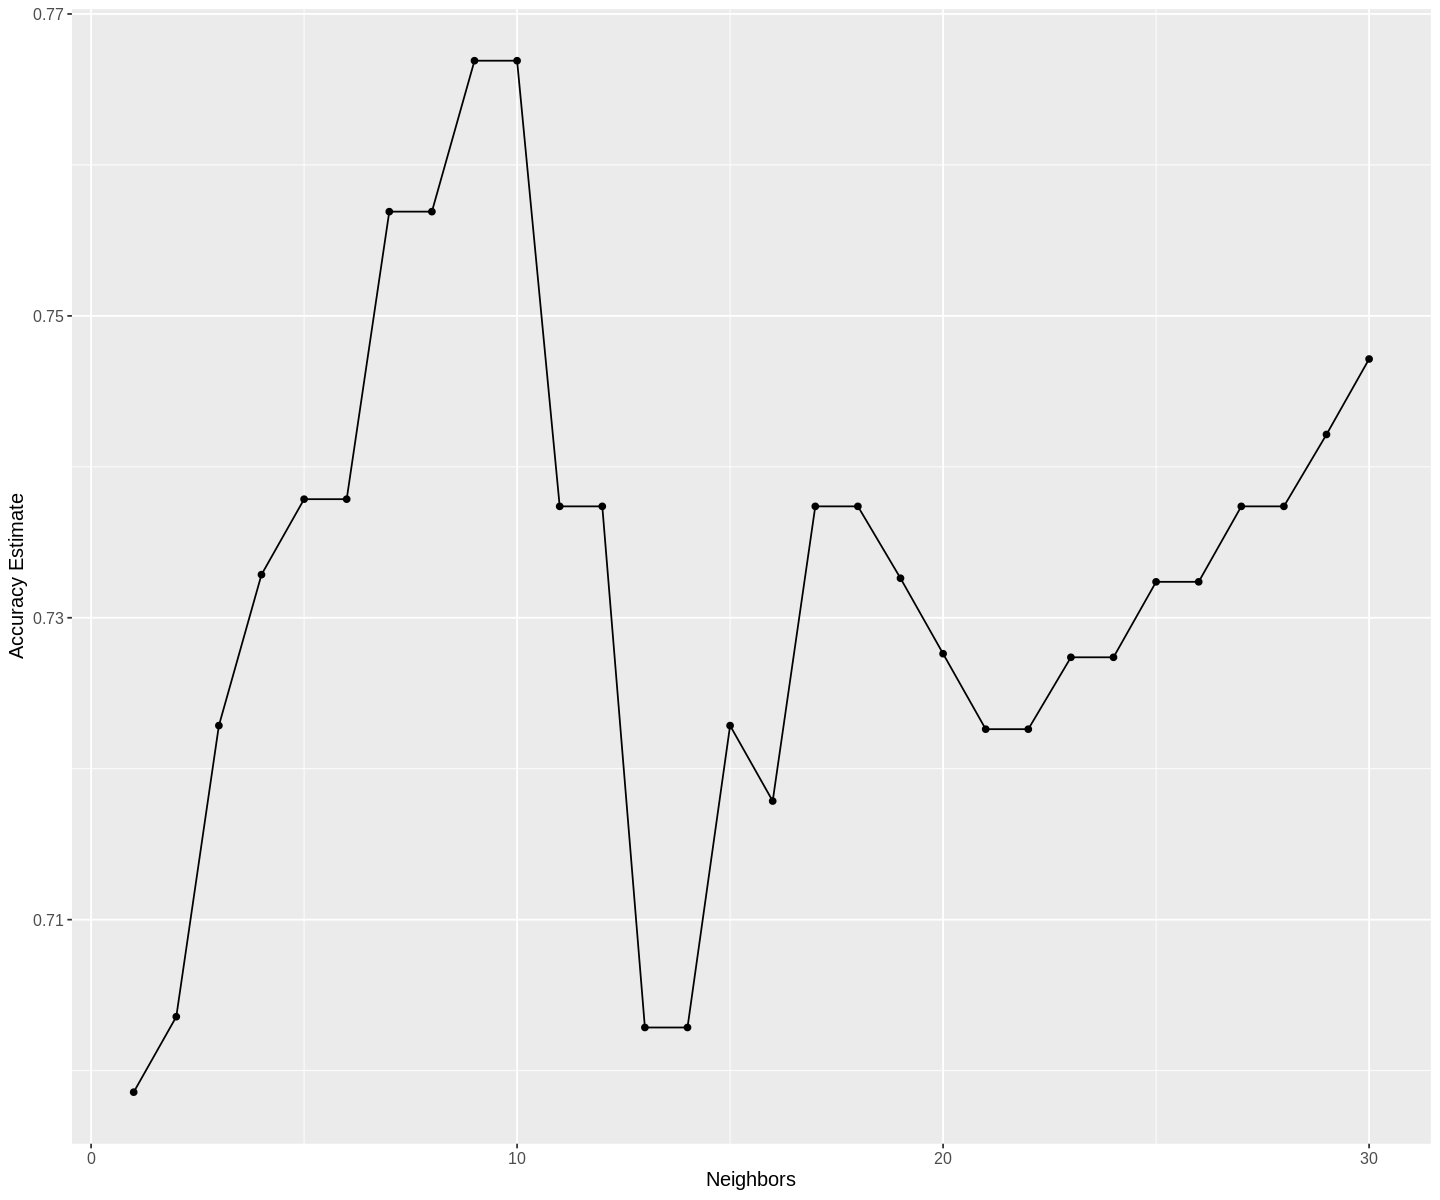

In [173]:
set.seed(2021)
heart_recipe <- recipe(`Heart Disease` ~ Age + `ST depression`, data = heart_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

knn_spec_tuning <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

heart_vfold <- vfold_cv(heart_train, v = 10, strata = `Heart Disease`)

k_vals <- tibble(neighbors = seq(from = 1, to = 30, by = 1))

knn_results <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(knn_spec_tuning) |>
  tune_grid(resamples = heart_vfold, grid = k_vals) |>
  collect_metrics() 

accuracies <- knn_results |>
  filter(.metric == "accuracy")

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12))

accuracy_vs_k

In [174]:
#found the k with most accuracy
maxaccuracies <-accuracies|>arrange(desc(mean))
maxaccuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
9,accuracy,binary,0.7669048,10,0.02722916,Preprocessor1_Model09
10,accuracy,binary,0.7669048,10,0.02722916,Preprocessor1_Model10
7,accuracy,binary,0.7569048,10,0.02213831,Preprocessor1_Model07
⋮,⋮,⋮,⋮,⋮,⋮,⋮
13,accuracy,binary,0.7028571,10,0.02684558,Preprocessor1_Model13
14,accuracy,binary,0.7028571,10,0.02684558,Preprocessor1_Model14
1,accuracy,binary,0.6985714,10,0.03293832,Preprocessor1_Model01


In [189]:
#predict the test set

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 9) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(knn_spec) |>
  fit(data = heart_train)

heart_test_predictions <- predict(knn_fit, heart_test) |>
  bind_cols(heart_test)

heart_test_predictions |>
  metrics(truth = `Heart Disease`, estimate = .pred_class) |>
  filter(.metric == "accuracy")

confusion <- heart_test_predictions |>
  conf_mat(truth = `Heart Disease`, estimate = .pred_class)
confusion


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.5735294


          Truth
Prediction Presence Absence
  Presence       15      14
  Absence        15      24

In [201]:
#filtering for male and female
set.seed(2022)
heart_data_male <- filter(heart_data,Sex==1)
heart_data_female <- filter(heart_data,Sex==0)

heart_split_male <- initial_split(heart_data_male, prop = 3/4, strata = `Heart Disease`)  
heart_train_male <- training(heart_split_male)   
heart_test_male <- testing(heart_split_male)

heart_split_female <- initial_split(heart_data_female, prop = 3/4, strata = `Heart Disease`)  
heart_train_female <- training(heart_split_female)   
heart_test_female <- testing(heart_split_female)

male_hd_proportions <- group_by(heart_train_male,`Heart Disease`)|>
                       summarize(n=n())|>
                       mutate(percent = 100*n/nrow(heart_train_male))
male_hd_proportions

female_hd_proportions <- group_by(heart_train_female,`Heart Disease`)|>
                       summarize(n=n())|>
                       mutate(percent = 100*n/nrow(heart_train_female))
female_hd_proportions

Heart Disease,n,percent
<chr>,<int>,<dbl>
Absence,62,45.25547
Presence,75,54.74453


Heart Disease,n,percent
<chr>,<int>,<dbl>
Absence,50,76.92308
Presence,15,23.07692


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
15,accuracy,binary,0.6626007,10,0.03003114,Preprocessor1_Model15
16,accuracy,binary,0.6626007,10,0.03003114,Preprocessor1_Model16
19,accuracy,binary,0.6626007,10,0.02370092,Preprocessor1_Model19
⋮,⋮,⋮,⋮,⋮,⋮,⋮
29,accuracy,binary,0.6020879,10,0.04036110,Preprocessor1_Model29
1,accuracy,binary,0.5797436,10,0.05335351,Preprocessor1_Model01
2,accuracy,binary,0.5797436,10,0.05335351,Preprocessor1_Model02


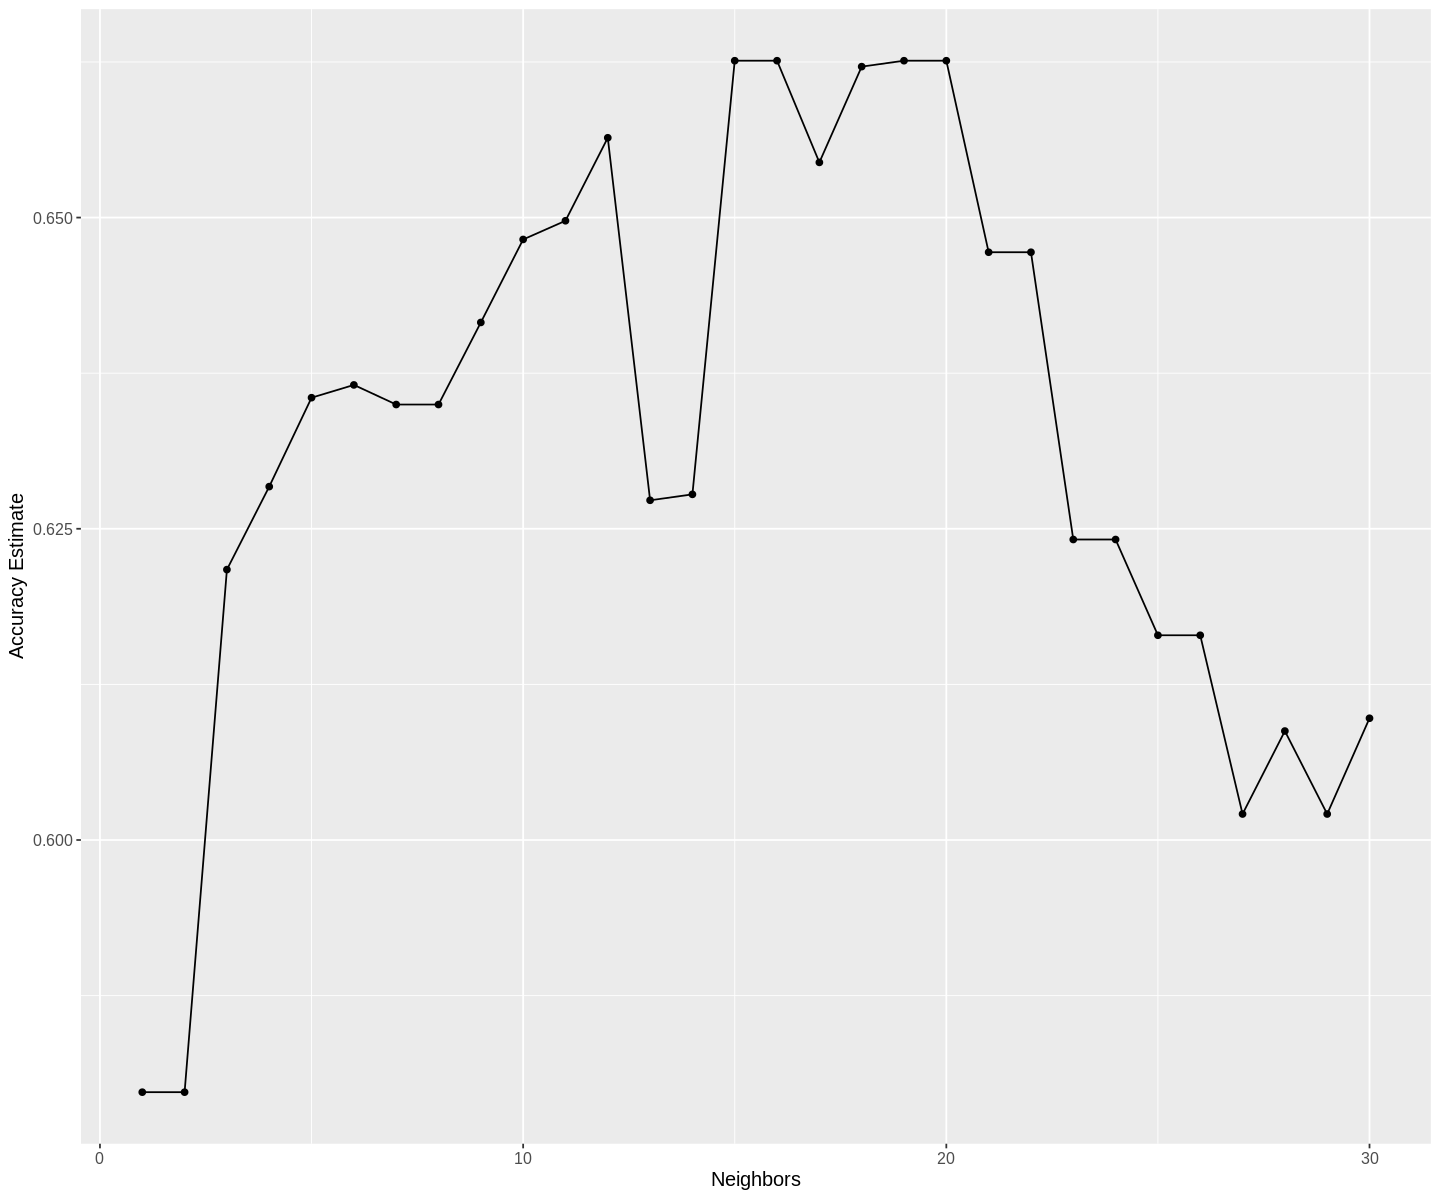

In [190]:
#work for male only
set.seed(2021)
heart_recipe_male <- recipe(`Heart Disease` ~ Age + `ST depression`, data = heart_train_male) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

knn_spec_tuning_male <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

heart_vfold_male <- vfold_cv(heart_train_male, v = 10, strata = `Heart Disease`)

knn_results_male <- workflow() |>
  add_recipe(heart_recipe_male) |>
  add_model(knn_spec_tuning_male) |>
  tune_grid(resamples = heart_vfold_male, grid = k_vals) |>
  collect_metrics() 

accuracies_male <- knn_results_male |>
  filter(.metric == "accuracy")

accuracy_vs_k_male <- ggplot(accuracies_male, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12))
accuracy_vs_k_male

maxaccuracies_male <-accuracies_male|>arrange(desc(mean))
maxaccuracies_male



In [191]:
#predict male presense of heart disease
knn_spec_male <- nearest_neighbor(weight_func = "rectangular", neighbors = 10) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit_male <- workflow() |>
  add_recipe(heart_recipe_male) |>
  add_model(knn_spec_male) |>
  fit(data = heart_train_male)

heart_test_predictions_male <- predict(knn_fit_male, heart_test_male) |>
  bind_cols(heart_test_male)

heart_test_predictions_male |>
  metrics(truth = `Heart Disease`, estimate = .pred_class) |>
  filter(.metric == "accuracy")

confusion_male <- heart_test_predictions_male |>
  conf_mat(truth = `Heart Disease`, estimate = .pred_class)
confusion_male


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.673913


          Truth
Prediction Presence Absence
  Presence       17       7
  Absence         8      14

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
7,accuracy,binary,0.8404762,10,0.04124694,Preprocessor1_Model07
8,accuracy,binary,0.8404762,10,0.04124694,Preprocessor1_Model08
5,accuracy,binary,0.8285714,10,0.03527954,Preprocessor1_Model05
⋮,⋮,⋮,⋮,⋮,⋮,⋮
11,accuracy,binary,0.7261905,10,0.03675726,Preprocessor1_Model11
12,accuracy,binary,0.7261905,10,0.03675726,Preprocessor1_Model12
14,accuracy,binary,0.7261905,10,0.03675726,Preprocessor1_Model14


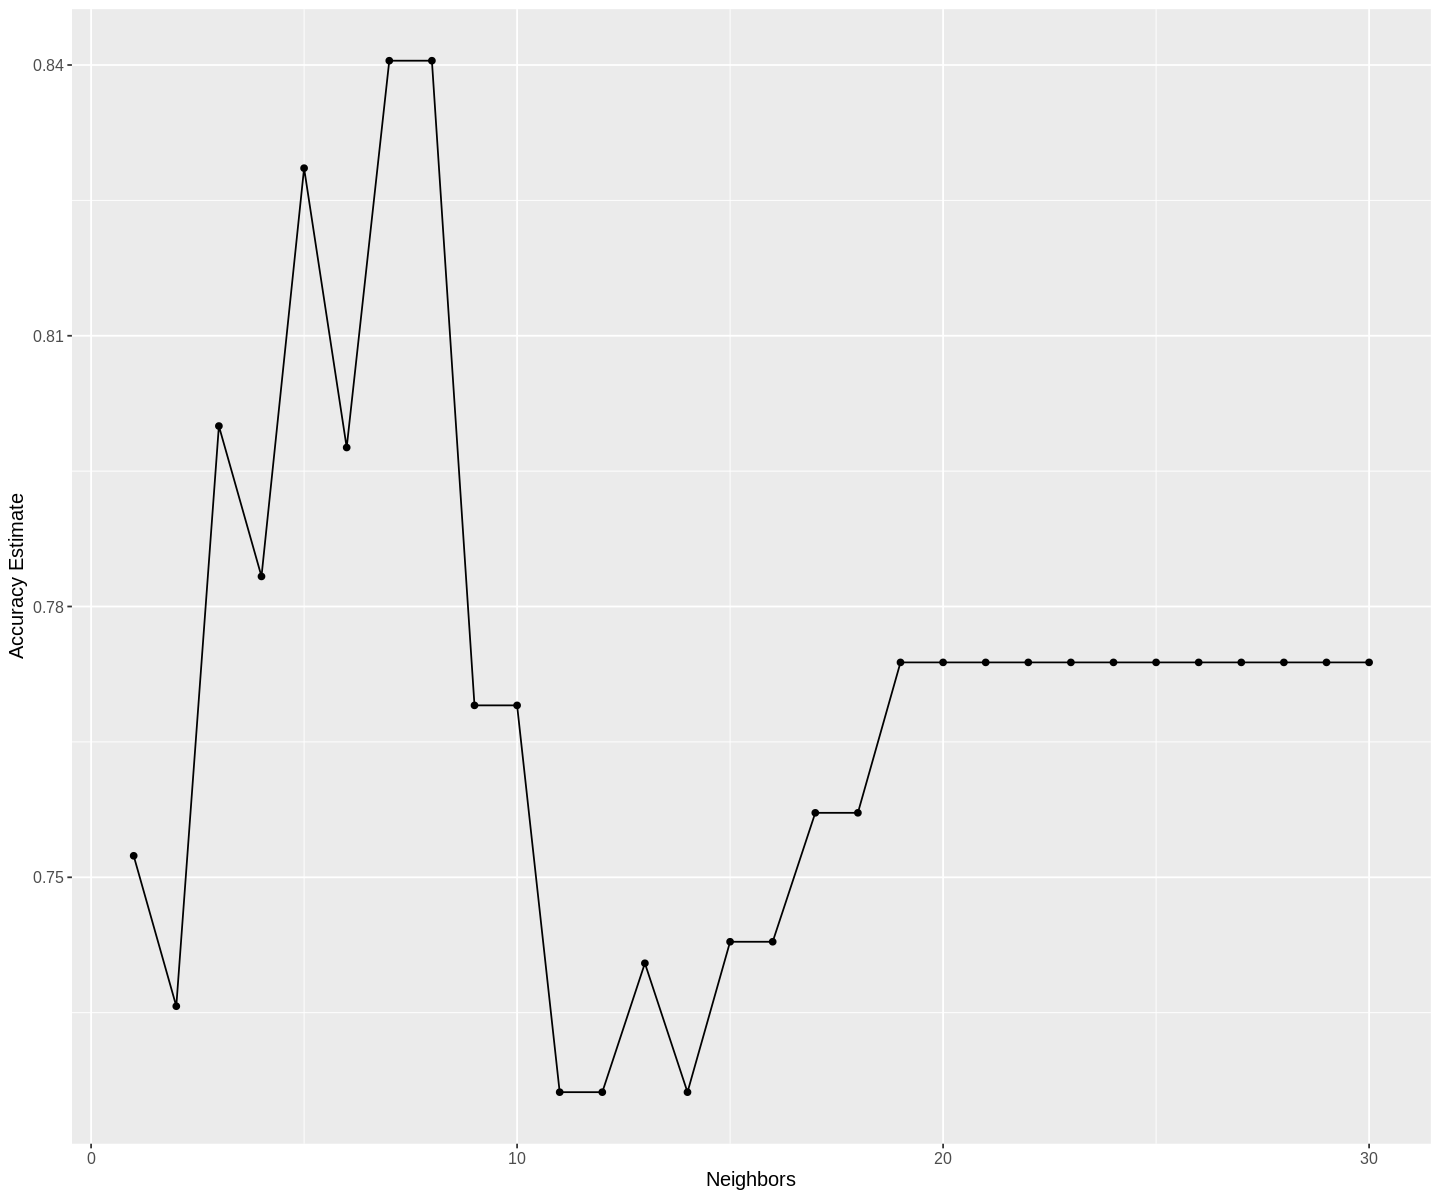

In [178]:
#working for female
set.seed(2021)
heart_recipe_female <- recipe(`Heart Disease` ~ Age + `ST depression`, data = heart_train_female) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

knn_spec_tuning_female <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

heart_vfold_female <- vfold_cv(heart_train_female, v = 10, strata = `Heart Disease`)

knn_results_female <- workflow() |>
  add_recipe(heart_recipe_female) |>
  add_model(knn_spec_tuning_female) |>
  tune_grid(resamples = heart_vfold_female, grid = k_vals) |>
  collect_metrics() 

accuracies_female <- knn_results_female |>
  filter(.metric == "accuracy")

accuracy_vs_k_female <- ggplot(accuracies_female, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12))

accuracy_vs_k_female

maxaccuracies_female <-accuracies_female|>arrange(desc(mean))
maxaccuracies_female

In [186]:
#predict female presense of heart disease
knn_spec_female <- nearest_neighbor(weight_func = "rectangular", neighbors = 7) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit_female <- workflow() |>
  add_recipe(heart_recipe_female) |>
  add_model(knn_spec_female) |>
  fit(data = heart_train_female)

heart_test_predictions_female <- predict(knn_fit_female, heart_test_female) |>
  bind_cols(heart_test_female)

heart_test_predictions_female |>
  metrics(truth = `Heart Disease`, estimate = .pred_class) |>
  filter(.metric == "accuracy")

confusion_female <- heart_test_predictions_female |>
  conf_mat(truth = `Heart Disease`, estimate = .pred_class)
confusion_female

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7727273


          Truth
Prediction Presence Absence
  Presence        3       3
  Absence         2      14